<a href="https://colab.research.google.com/github/yaelbab66/AddUser/blob/main/HW_036737062_214544991.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 01
# Image Classification

**036737062 Yael Babichenko ,**

**214544991 Shahar Rozenberg**

### Objective
In this assignment, the goal is to implement a Convolutional Neural Network (CNN) for image classification on the EMNIST Letters dataset. The dataset consists of hand written letters in the English alphabet.


### Instructions

The assignment is arranged in sections, each section includes its instructions with coding tasks, and open ended questions. The provided code offers a starting point, in your tasks you should add code to sections that have the comment `#TODO` at the top. And **never delete** given code.

### Submission Guidelines

*   Assignments are done in pairs, include both ids in the filename when submitting (e.g. *HW01_123456789_123456789.ipynb*) and in the begining of file.
*   Submit only one Jupyter notebook containing your code modifications, comments, and analysis.
*   Include visualizations, graphs, or plots to support your analysis where needed.
*   Provide a conclusion summarizing your findings, challenges faced, and potential future improvements.
*   Notice the approximate runtime for some code sections.


### Important Notes

*  Ensure clarity in code comments and explanations for better understanding.
*  Experiment, analyze, and document your observations throughout the assignment.
*  Feel free to train on GPU (see example in practice 2-3 notebook).
*  It is recommended to explore the datasest and understand it well before implementation.
*  Feel free to seek clarification on any aspect of the assignment in the provided forum in moodle.

In [ ]:
# arrange any/all imports here

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch.nn as nn

from tqdm import tqdm
import math

# vizualization and plots
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Section 1: Data Understanding and Preparation

In this section we will load, explore and prepare the dataset for training.

You are given a dataset of grayscale images, each 28x28 pixels, representing handwritten letters (A-Z). The dataset is called* EMNIST Letters* you can read more about it [here](https://www.kaggle.com/datasets/crawford/emnist). The dataset will be downloaded to local enviroment using the `tourchvision`. Your tasks in this section are:

1. Describe how you would preprocess the data for a CNN explain your choice of transofrmation. Implement the preprocessing of your choice in the `transform` code section below.
2. Create train loader for the trian and test sets. Explain your choice of `batch_size`.

In [ ]:
# Define transformations for the dataset
# transform: Normalization makes sure the input features have a consistent range and pattern, helping the model train faster and learn better.
transform = transforms.Compose([ transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize(mean = (0.1736,), std = (0.3248,))
])
# The mean and std were taken from EMNIST github https://github.com/XavierSpycy/EMNIST-Classifier

In [ ]:
# Load the EMNIST Letters dataset
# loading the set takes approx 3 mins

train_dataset = torchvision.datasets.EMNIST(
  root='./data',
  split='letters',
  train=True,
  download=True,
  transform=transform
)

test_dataset = torchvision.datasets.EMNIST(
  root='./data',
  split='letters',
  train=False,
  download=True,
  transform=transform
)

# Inspect the dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Shape of one image: {train_dataset[0][0].shape} (C x H x W)")

100%|██████████| 562M/562M [00:09<00:00, 62.3MB/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
Number of training samples: 124800
Number of testing samples: 20800
Shape of one image: torch.Size([1, 32, 32]) (C x H x W)


In [ ]:
train_dataset.classes

['N/A',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [ ]:
# Define relevant variables for the ML task
# To keep the balance between stability and generalization, we choose a standard batch_size.
batch_size = 64
num_classes = 26
learning_rate = 0.001
num_epochs = 5

# Device will determine whether to run the training on GPU or CPU.
# We have used the GPU when trained and evaluated the models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
# Create data loaders for training and testing

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

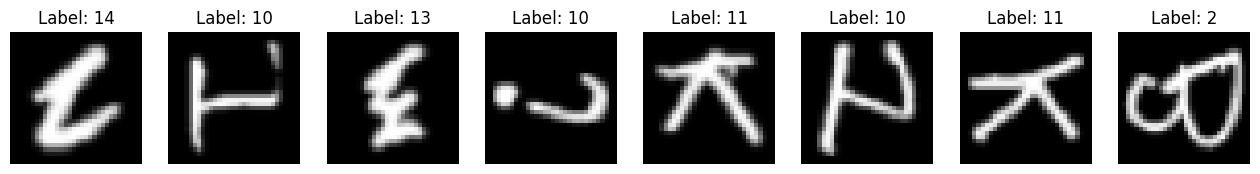

In [ ]:
# This code section displays the first 8 images in the batch.

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
  axes[i].imshow(images[i].squeeze(0), cmap='gray')
  axes[i].set_title(f"Label: {labels[i].item()}")
  axes[i].axis('off')
plt.show()

## Section 2: CNN Model Design

Design a simple CNN to classify the dataset mentioned above. Your network should include at least two convolutional layers, one pooling layer, and a fully connected layer. The model architicture should be in the following order:

*   Convolutional Layer 1: Implement a convolutional layer with 32 output channels, a 3x3 kernel size, a stride of 1, and a padding of 1.
*   Batch Norm Layer.
*   ReLU Activation Layer.
*   MaxPooling Layer: Add a max-pooling layer with a 2x2 kernel size and a stride of 2.

*   Convolutional Layer 2: Implement a convolutional layer with 64 output channels, a 3x3 kernel size, a stride of 1, and a padding of 1.
*   Batch Norm Layer.
*   ReLU Activation Layer.
*   MaxPooling Layer: like above.

*  Fully Connected Layer 1 (Input Size: Dynamically Inferred Based on Previous Layer Output): Include a fully connected (linear) layer with an input size that is dynamically inferred based on the output size of the previous convolutional layer. Output size 128.

* RelU Activation Function.

*  Fully Connected Layer 2: Add a final fully connected (linear) layer with 26 output features, representing the 26 alphabet letters.


In [ ]:
# Define the CNN architecture

class EMNIST_CNN(nn.Module):
  def __init__(self, num_classes=26):
    super(EMNIST_CNN, self).__init__()

    self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

    self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))


    self.fc = nn.Linear(4096, 128)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(128, num_classes)


  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    out = self.relu(out)
    out = self.fc1(out)
    return out

## Section 3: Training and Optimization

In this section we will setup all training parameters and train the model. your tasks in this section are:
1. Create an instance of the model.
2. Choose and explain your choice of optimizer and loss function.
3. Fill the missing code in the training function.
4. Train a model for 5 epochs on the training set (in colab CPU should take ~20 mins).


**Note**: EMNIST labels start from 1 to 26, skipping 0. But our models' results are indexed from 0 to 25.


In [ ]:
# Create an instance of the model
model = EMNIST_CNN(num_classes).to(device)

**Loss Function:** ***Cross Entropy***

It measures the difference between predicted probabilities and true class labels.
(The function expects raw logits (unnormalized scores) from the model's output.)

**Optimizer:** ***Adam***

Adam is chosen for its adaptive learning rate and fast convergence properties.
It works well with minimal hyperparameter tuning.

In [ ]:
# Loss Function: Cross Entropy
cost = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

In [ ]:
# Training function partially implemented for assignment
def train_model(model, loader, optimizer, loss, num_epochs=5):

  model.train() # set model to train
  for epoch in range(num_epochs):

    # create variables to print loss and training accuracy per epoch
    epoch_loss = 0
    total = 0
    correct = 0


    for images, labels in tqdm(loader):
      optimizer.zero_grad()
      images, labels = images.to(device), (labels - 1).to(device)  # EMNIST labels are 1-based

      outputs = model(images)

      loss = cost(outputs, labels)

      loss.backward()
      optimizer.step()

      # epoch loss and accuracy for printing
      epoch_loss += loss.item()
      _, predicted = model(images).max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    # Printing the loss and accuracy for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(loader):.4f}, Accuracy: {100 * correct/total:.2f}%")


In [ ]:
# train the model.
# training the model for 5 epochs on CPU in colab should take ~20 mins.
# training the model for 5 epochs on GPU in colab took ~3 mins.
# 93.66 test accuracy, 95.01 training accuracy and 92.99%  test accuracy
train_model(model, train_loader, optimizer, cost, num_epochs=5)

100%|██████████| 1950/1950 [00:45<00:00, 43.19it/s]


Epoch [1/5], Loss: 0.3996, Accuracy: 88.97%


100%|██████████| 1950/1950 [00:44<00:00, 43.96it/s]


Epoch [2/5], Loss: 0.2290, Accuracy: 93.52%


100%|██████████| 1950/1950 [00:43<00:00, 44.83it/s]


Epoch [3/5], Loss: 0.1914, Accuracy: 94.42%


100%|██████████| 1950/1950 [00:45<00:00, 43.11it/s]


Epoch [4/5], Loss: 0.1658, Accuracy: 95.08%


100%|██████████| 1950/1950 [00:43<00:00, 44.95it/s]

Epoch [5/5], Loss: 0.1460, Accuracy: 95.66%


## Section 4: Evaluate the Model Preformance

The following method evaluates a given model on the loaded test set. Use it to evaluate your trained model on the test set loader. And answer the open-ended questions written below.

In [ ]:
# Evaluation function
def evaluate_model(model, loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in loader:
      images, labels = images.to(device), (labels - 1).to(device)
      outputs = model(images)
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  print(f"Test Accuracy: {accuracy:.2f}%")

  return accuracy

In [ ]:
# evaluate your model
eval_cnn = evaluate_model(model, test_loader)

Test Accuracy: 93.50%


Answer the following open ended questions.

1. *If the CNN underperforms, what architectural modifications could improve its performance (e.g., depth, kernel size, activation functions)? Justify your choices.*

2. *How do the choices of batch size, learning rate, and optimizer affect the training process and final performance of your CNN? Provide examples from your results.*

# Answers:

***Question 1:***
1. There are several ways to improve the architecture of the CNN models.
First, we can **increase the depth** of the neural network. As we know, the deeper the network is (meaning more layers to the network), the closer the predictions get to the actual values. Of course we can accidentally get to the overfitting area, but if the model underperforms - it increases the chances that a deeper neural network will "catch" the real values.

2.	Another option is to alter the kernel itself so it will get more data from each image. The most intuitive way to do so is to **decrease the kernel size**, which will result in smaller kernels. This means that every kernel will have significantly more iterations per image, because there is a smaller window that must go over the same size of each image. We can also **increase the padding**, and as a result there will be more iterations per image, specifying on the edges. As we know, the edges are quite small parts of each image, but in small images like letters - they are important for the classification of the numbers. Therefore, getting bigger value to the edges can increase the performance of the mode

***Question 2:***
1. The choice of batch size is important and plays a significant role in the tradeoff of better-performance : convergence-rate. When the batch size is small (meaning fewer datapoints taken into consideration per iteration), we get a more accurate representation of the dataset (giving more weight to each datapoint) but we are doing way more iterations, so the convergence rate is slower. On the other hand, taking too big batches will do the opposite as we can lose crucial knowledge from the data.

2. In the case of learning rate, it is also important to find the optimal one. A small learning rate requires many updates before reaching the minimum point, while on the other hand a learning rate that is too large causes drastic updates which lead to divergent behaviors.

3. The optimizer also affects the performance, as it uses smart methods to calculate the gradients and update the parameters as fast and accurate as possible. Choosing a good optimizer is important, and we know that ADAM is the best one (or at least the most used one).


## Section 5: FeedForward Network

In this section you will suggest a feedforward architecture to solve the same problem above, classify the EMNIST images. tasks:


1.   Suggest a feedforward model to solve the same problem the CNN above was trained on. Explain and implement your choice in `EMNIST_FeedForward` class
2.   Train the model on the same dataset - you can reuse the `train_model` method defined above. Explain your choice of loss function and optimizer. (training a 3 layer model takes approx 5 mins on colab CPU)
3.   Evaluate the feedforward model preformance on the test set, again, you can reuse the `evaluate_model` method.




In [ ]:
# Feedforward Model - final try

# layer 3: fully-connected(1024, 512)
# layer 4: reLU
# layer 5: fully-connected(512, 256)
# layer 6: reLU
# layer 7: fully-connected(256, 128)
# layer 6: reLU
# layer 7: fully-connected(128, num_classes)
class EMNIST_FeedForward(nn.Module):
  def __init__(self, num_classes=26):
    super(EMNIST_FeedForward, self).__init__()

    self.fc1 = nn.Linear(1024, 512)
    self.relu1 = nn.ReLU()

    self.fc2 = nn.Linear(512, 256)
    self.relu2 = nn.ReLU()

    self.fc3 = nn.Linear(256, 128)
    self.relu3 = nn.ReLU()

    self.fc4 = nn.Linear(128, num_classes)  # Output layer


  def forward(self, x):
    out = x.view(x.size(0), -1)  # flatten the input tensor
    out = self.fc1(out)
    out = self.relu1(out)
    out = self.fc2(out)
    out = self.relu2(out)
    out = self.fc3(out)
    out = self.relu3(out)
    out = self.fc4(out)
    return out


In [ ]:
# Create an instance of the FeedForward model
ff_model = EMNIST_FeedForward(num_classes).to(device)

**Loss Function:** ***Cross Entropy***

It measures the difference between predicted probabilities and true class labels.
(The function expects raw logits (unnormalized scores) from the model's output.)

**Optimizer:** ***Adam***

Adam is chosen for its adaptive learning rate and fast convergence properties.
It works well with minimal hyperparameter tuning.

In [ ]:
# Loss Function: Cross Entropy
cost = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = torch.optim.Adam(ff_model.parameters(), lr=learning_rate)

total_step = len(train_loader)

In [ ]:
# train the feed-forward model.

train_model(ff_model, train_loader, optimizer, cost, num_epochs=5)

100%|██████████| 1950/1950 [00:38<00:00, 51.13it/s]


Epoch [1/5], Loss: 0.5583, Accuracy: 85.13%


100%|██████████| 1950/1950 [00:37<00:00, 51.52it/s]


Epoch [2/5], Loss: 0.3090, Accuracy: 91.91%


100%|██████████| 1950/1950 [00:37<00:00, 51.38it/s]


Epoch [3/5], Loss: 0.2574, Accuracy: 93.32%


100%|██████████| 1950/1950 [00:37<00:00, 52.13it/s]


Epoch [4/5], Loss: 0.2277, Accuracy: 94.00%


100%|██████████| 1950/1950 [00:38<00:00, 50.97it/s]

Epoch [5/5], Loss: 0.2042, Accuracy: 94.62%


In [ ]:
# Evaluate your FeedForward model
eval_ff = evaluate_model(ff_model, test_loader)

Test Accuracy: 90.88%


## Section 6 - Compare & Discuss

In this section we will compare the two approaches.

### 6.1 Comparing Architectures

*After design a feedforward network and a CNN for the same dataset, explain how they differ in terms of:*




#### 1.   *Number of parameters*

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

parameter_counts = {
    "Model": ["Feedforward Network", "Convolutional Neural Network (CNN)"],
    "Total Parameters": [count_parameters(ff_model), count_parameters(model)]
}

# Display nicely
df = pd.DataFrame(parameter_counts)
print(df.to_markdown(index=False))


| Model                              |   Total Parameters |
|:-----------------------------------|-------------------:|
| Feedforward Network                |             692378 |
| Convolutional Neural Network (CNN) |             546778 |


* We can see that the number of parameters in the CNN model is smaller. It is probablly due to the local connections and shared weights.

#### 2.   *Ability to capture spatial relationships*

* We know from the lectures that in *fully connected neural network* (like our FeedForward model), every information about *spatial notion* (i.e., location of the pixels) *is lost* due to flattening the image.

* On the other hand, in *CNN models* we use *spatial information as input*.
We do so by connecting each patch in the input layer to a single neuron in the subsequent layer, and then using a sliding window to define connections which results in capturing spatial relationships effectively.

#### 3.   *Success/failure in solving the classification task*


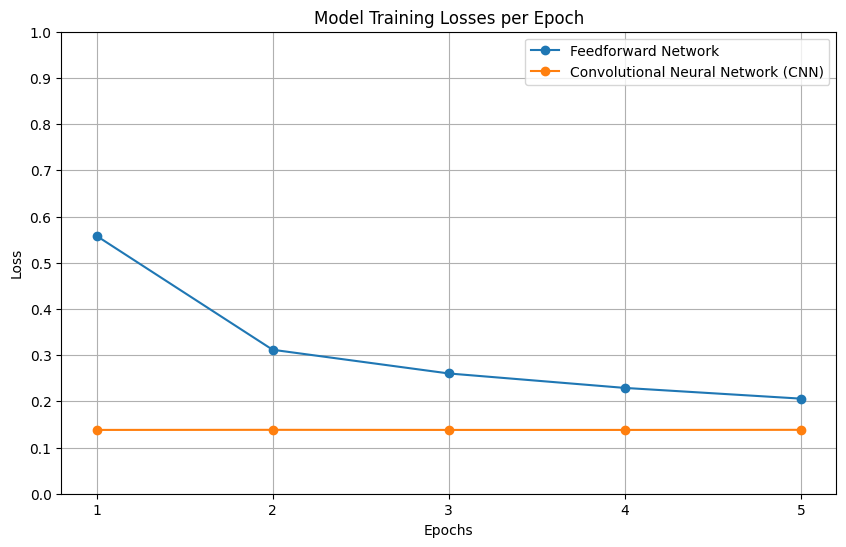

In [ ]:
epochs = [1, 2, 3, 4, 5]
cnn_losses = [0.1381, 0.1383, 0.1381, 0.1381, 0.1383]
ff_losses = [0.5582, 0.3116, 0.2603, 0.2290, 0.2058]

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, ff_losses, marker='o', label='Feedforward Network')
plt.plot(epochs, cnn_losses, marker='o', label='Convolutional Neural Network (CNN)')

# Add labels, title, and legend
plt.ylim(0, 1)
plt.xticks(epochs)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training Losses per Epoch')
plt.legend()
plt.grid(True)
plt.show()


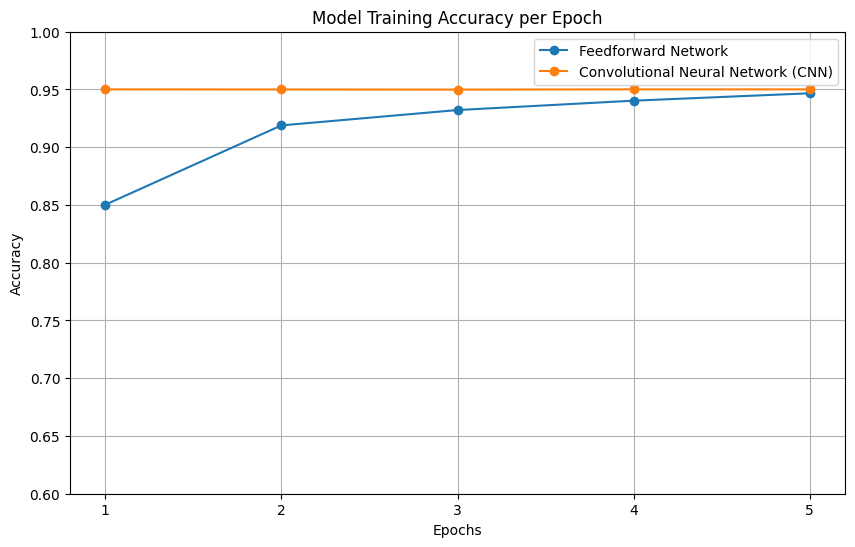

In [ ]:
epochs = [1, 2, 3, 4, 5]

cnn_accuracy = [0.9501, 0.95, 0.9499, 0.9501, 0.9501]
ff_accuracy = [0.8502, 0.9189, 0.9322, 0.9403, 0.9467]

# Plot the Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, ff_accuracy, marker='o', label='Feedforward Network')
plt.plot(epochs, cnn_accuracy, marker='o', label='Convolutional Neural Network (CNN)')

# Add labels, title, and legend
plt.ylim(0.6, 1)
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Training Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

* We can see very easily from the plots that although both NN were strong, the CNN model was more accurate and converged faster.

* The test accuracy was also better for the CNN:

In [ ]:
parameter_counts = {
    "Model": ["Feedforward Network", "Convolutional Neural Network (CNN)"],
    "Total Parameters": [eval_ff, eval_cnn]
}

# Display nicely
df = pd.DataFrame(parameter_counts)
print(df.to_markdown(index=False))

| Model                              |   Total Parameters |
|:-----------------------------------|-------------------:|
| Feedforward Network                |            90.8846 |
| Convolutional Neural Network (CNN) |            93.5048 |


### 6.2 Visualize Filters & Feature Maps

Run the following code sections in order to visualize the filters and feature maps of the first layer in your trained CNN. Answer the questions below afterwards.

Notice, you must open the code and specify the name of your CNN model.

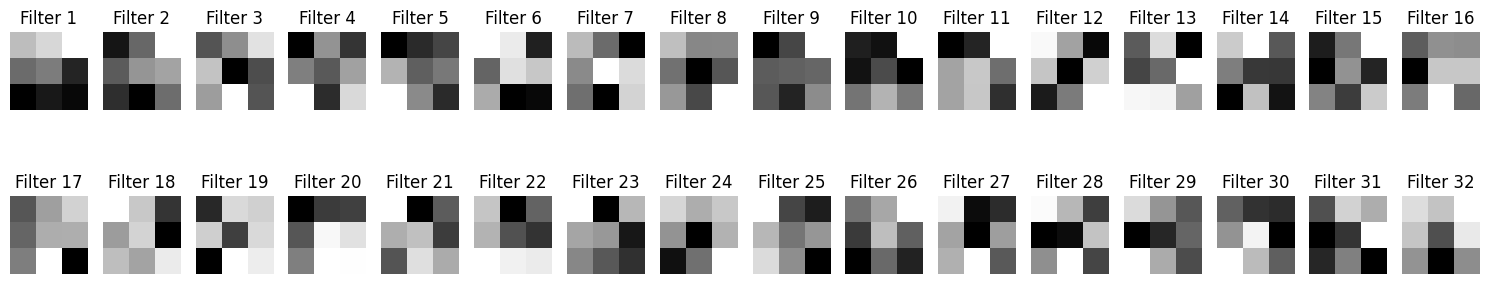

In [ ]:
#@title Visualizing Kernels from the First Convolutional Layer
#@markdown Open code to edit model name.

cnn_model = model #ADD YOU MODEL INSTANCE NAME HERE.

# Access the first convolutional layer's filters
filters = cnn_model.layer1[0].weight.data.cpu()  # Shape: (num_filters, input_channels, F, F)

# Number of filters
num_filters = filters.shape[0]

# Calculate grid dimensions for visualization (rows x cols)
grid_cols = 16  # You can adjust this value
grid_rows = math.ceil(num_filters / grid_cols)

# Create a grid of subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, grid_rows * 2))
axes = axes.flatten()  # Flatten for easier indexing

# Plot each filter
for i, ax in enumerate(axes):
    if i < num_filters:
        # Select the first channel of each filter (assuming grayscale)
        filter_ = filters[i, 0, :, :]

        # Normalize filter values to [0, 1]
        filter_ = (filter_ - filter_.min()) / (filter_.max() - filter_.min())

        # Plot the filter
        ax.imshow(filter_.numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')
    else:
        # Turn off unused axes
        ax.axis('off')

plt.tight_layout()
plt.show()


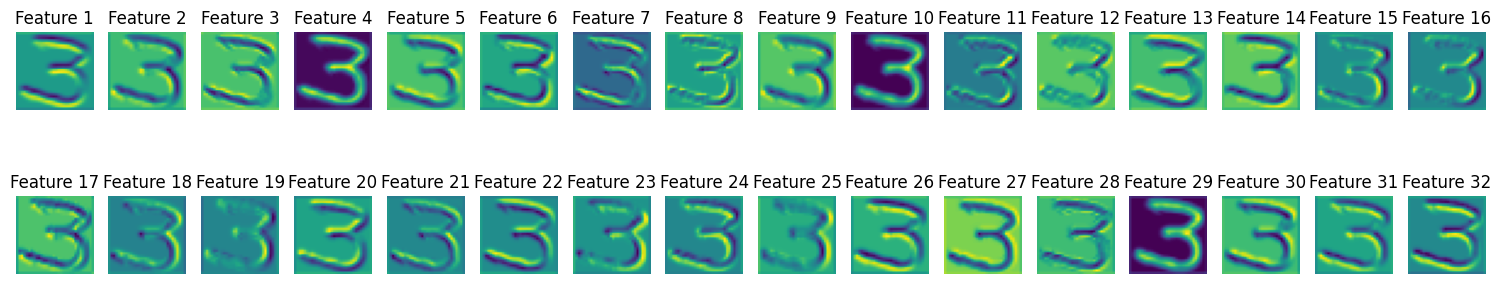

In [ ]:
#@title Visualizing Feature Maps from the First Convolutional Layer
#@markdown Change the image id and run the code cell to view different images.

#@markdown Open code to edit model name.
image_id = 57  #@param {type: "slider", min: 0, max: 63}
cnn_model = model #ADD YOU MODEL INSTANCE NAME HERE.
# image_id = 10  #@param {type: "number"}

# Use a trained model
cnn_model.eval()

# Load one image from the dataset (assuming the data is normalized)
image, _ = next(iter(test_loader))  # Assuming test_loader is defined
image = image[image_id].unsqueeze(0).to(device)  # Select an image and add batch dimension

# Pass the image through the first convolutional layer
with torch.no_grad():
    conv1_output = cnn_model.layer1[0](image)  # Assuming 'layer1[0]' is the first conv layer

# Get the number of feature maps
num_feature_maps = conv1_output.shape[1]

# Calculate grid dimensions for visualization
grid_cols = 16  # You can adjust this
grid_rows = math.ceil(num_feature_maps / grid_cols)

# Create a grid of subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, grid_rows * 2))
axes = axes.flatten()

# Plot each feature map
for i, ax in enumerate(axes):
    if i < num_feature_maps:
        # Visualize the ith feature map
        ax.imshow(conv1_output[0, i].cpu().numpy(), cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Feature {i+1}')
    else:
        # Turn off unused axes
        ax.axis('off')

plt.tight_layout()
plt.show()


**What Are Feature Maps?**

  Each feature map corresponds to the activation of one filter in the convolutional layer.

  Filters detect specific features from the input image.

  The values in a feature map indicate how strongly a specific feature was detected at each spatial location in the input.


**Understanding the Color Map**

  The Viridis color map (default in Matplotlib) uses a gradient of colors:

  *  Purple (low values): Indicates weak or no activation at a particular spatial location. The filter didn't find much of its target feature in this area.
  *  Green (high values): Indicates strong activation. The filter detected its target feature strongly in this region of the input.

Given the visualizations and explanation above, answer the following questions:



---



*1. Are there any filters that have almost no activation across all features maps? Assume there are such filters, what might this indicate about the training process or the architecture?*

**Answer Q1:**

The network might have more filters than necessary for the given task, causing some filters to become redundant.

The model might be overly complex for the dataset and could benefit from pruning or a smaller architecture.

Another reason might be poor weight initialization, which can prevent some filters from learning effectively.

*2. Based on the activations in the feature maps, do you think the model is focusing on important parts of the input image? How could you modify the model if you suspect it's not focusing on the right features?*

**Answer Q2:**

The model focuses on important parts of the input image, it indicates that the activations are appropriate for the task.

If we suspect the model is not focusing on the right features, we can try modifying the loss function to increase the penalty for being out of focus.

Additionally, we could train on a few "problematic" input images separately to address the focus issue.